In [1]:
import sys
import math
from collections import defaultdict
from collections import Counter

import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import peakutils
import ltfatpy

import note as notepy
import rion


In [2]:
# Run this to get plots in the notebook
%matplotlib inline

In [ ]:
# Run this to get interactive plots
%matplotlib qt

# Sample Import and Preprocess
In these snippets, we import a sample of a piano playing an Ab3/G\#3, recorded through a phone mic.

Text(0.5,0,'Time [s]')

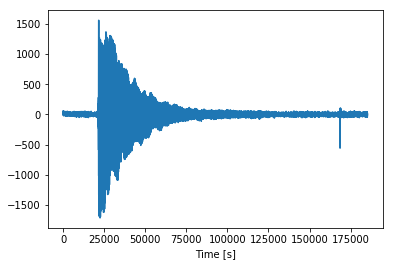

In [3]:
# Load sample
sample_file = 'samples/piano_Ab3.wav'
fs, x = scipy.io.wavfile.read(sample_file)

plt.plot(x)
plt.xlabel('Time [s]')


Text(0.5,0,'Time [s]')

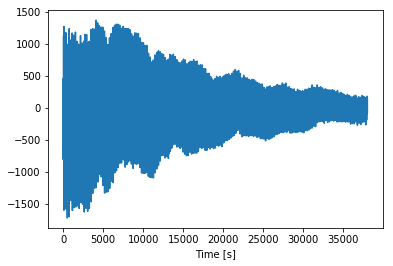

In [4]:
# Cut sample
x = x[22000:60000]

plt.plot(x)
plt.xlabel('Time [s]')


# Note Detection
Here, we run a filter on the frequency domain to gather the strength of each note in the timbre.

(0, 5000)

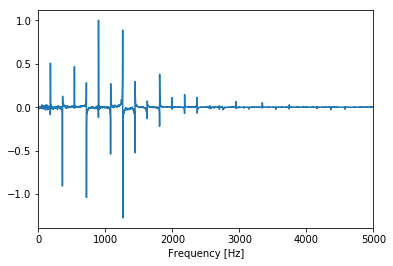

In [5]:
# Take a look at the frequency domain
X = np.real(np.fft.fft(x))
X = X/np.max(X)

plt.plot(X)
plt.xlabel('Frequency [Hz]')
plt.xlim([0,5000])


(32, 78)

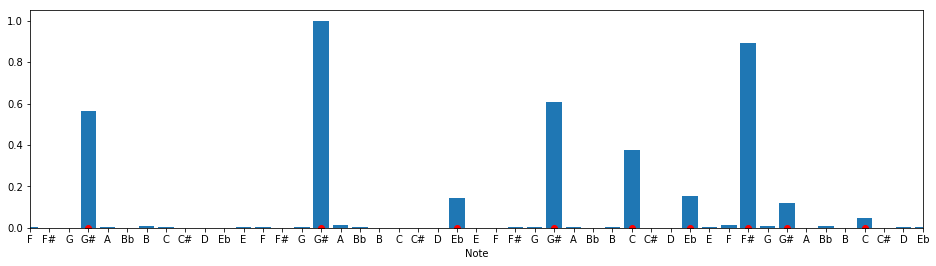

In [6]:
# Put X into note buckets
X_notes, notes = rion.note_filter(x, fs)
X_notes = X_notes / np.max(X_notes)
note_names = [note.name for note in notes]

# TODO: Thresholding might work better for note clusters
# Get loud notes
peaks = peakutils.indexes(X_notes, thres=0.02/max(X_notes), min_dist=1)

plt.figure(figsize = (16,4))
plt.bar(np.arange(len(X_notes)), X_notes)
plt.plot(peaks, np.zeros(len(peaks)), 'ro')
plt.xlabel('Note')
plt.xticks(np.arange(len(notes)), note_names)
plt.xlim([32,78])


### Note stats
An example of some statistics that can be gathered from our note filter.

Please note that the Note library increments octaves at A, instead of C, so the f_0 estimate of G\#2 is really an estimate of G\#3, which is correct ✔.

In [7]:
# Get peak notes
peak_notes = [notes[peak] for peak in peaks]
print('Notes in timbre are {}\n'.format([str(peak_note) for peak_note in peak_notes]))
f_0 = peak_notes[0]
print('f_0 is {}\n'.format(f_0))

# Peak tone count
print('Timbre tone count:')
peak_tones = dict(Counter([peak_note.name for peak_note in peak_notes]))
for w in sorted(peak_tones, key=peak_tones.get, reverse=True):
    print('{}\t{}'.format(w, peak_tones[w]))

# Sum of tone strengths
print('\nSum of tone strengths:')
tone_sums = defaultdict(int)
for note, vol in zip(notes, X_notes):
    tone_sums[note.name] += vol
for w in sorted(tone_sums, key=tone_sums.get, reverse=True):
    print('{}\t{}'.format(w, round(tone_sums[w],3)))


Notes in timbre are ['G#2', 'G#3', 'Eb4', 'G#4', 'C5', 'Eb5', 'F#5', 'G#5', 'C6']

f_0 is G#2

Timbre tone count:
G#	4
Eb	2
C	2
F#	1

Sum of tone strengths:
G#	2.301
F#	0.905
C	0.434
Eb	0.312
F	0.031
Bb	0.029
A	0.028
G	0.024
B	0.02
E	0.017
D	0.015
C#	0.007


# Pitch Detection via Spectrogram (work in progress)

In [ ]:
window = scipy.signal.get_window('triang', 2048)
f, t, Sxx = scipy.signal.spectrogram(x, fs, window=window)
plt.pcolormesh(t, f, Sxx)
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
